In [2]:
# Install scikit-learn in the notebook environment
%pip install scikit-learn

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error




[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#1. Load the data
df = pd.read_csv('/Users/noahpockriss/Winter Sprint 2026/data/final_data.csv')

#2. Pick features
features = ['age', 'height_in_cm', 'goals', 'assists', 'minutes_played', 'games_played']
X = df[features]
Y = df['market_value_in_eur']

#3. Split - keep 20% of data for testing later
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#4. Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

#5. Predict & Evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(Y_test, predictions)

print(f"Model Trained!")
print(f"Average Error: €{mae:,.0f}")

Model Trained!
Average Error: €6,301,443


In [4]:
#Error Analysis

#Create a DataFrame of the results
results = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})

#Add player names
results['Player'] = df.loc[Y_test.index, 'name']

#Calculate error for each player
results['Error'] = abs(results['Actual'] - results['Predicted'])

#Sort by biggest errors
top_errors = results.sort_values(by='Error', ascending=False).head(10)

pd.options.display.float_format = '€{:,.0f}'.format
print(top_errors[['Player', 'Actual', 'Predicted', 'Error']])

                   Player       Actual    Predicted       Error
3047          Cole Palmer €130,000,000  €44,678,500 €85,321,500
1588        Kylian Mbappé €170,000,000  €92,590,000 €77,410,000
2942      Franjo Ivanovic   €8,000,000  €76,840,000 €68,840,000
3139      Jude Bellingham €180,000,000 €112,400,000 €67,600,000
3704             Serginho   €1,700,000  €65,396,000 €63,696,000
3038          Xavi Simons  €70,000,000  €13,426,000 €56,574,000
4069        Kobbie Mainoo  €55,000,000   €6,708,500 €48,291,500
1513         Nicolas Kühn  €12,000,000  €58,350,000 €46,350,000
1293            Dani Olmo  €60,000,000  €14,342,500 €45,657,500
3977  Aleksandar Pavlovic  €50,000,000   €4,870,500 €45,129,500


In [15]:
#Check which leagues exist in the data
print(df['current_club_domestic_competition_id'].unique())

#Define the league coefficient dictionary
#Scores based on UEFA Association Club Coefficients 2025/26 (normalized to England = 1.0)

league_strength_map = {
    'GB1' : 1.00,   # Premier League (England) - 103.6 pts
    'IT1' : 0.89,   # Serie A (Italy) - 92.1 pts
    'ES1' : 0.83,   # La Liga(Spain) - 85.9 pts
    'L1'  : 0.80,   # Bundesliga (Germany) - 82.9 pts
    'FR1' : 0.73,   # Ligue 1 (France) - 75.5 pts
    'NL1' : 0.63,   # Eredivisie (Netherlands) - 65.7 pts
    'PO1' : 0.61,   # Liga Nos (Portugal) - 63.2 pts
    'BE1' : 0.56,   # Jupiler Pro (Belgium) - 57.7 pts
    'TR1' : 0.46,   # Super Lig (Turkey) - 48.1 pts
    'GR1' : 0.42,   # Super League (Greece) - 43.6 pts
    'DK1' : 0.38,   # Superliga (Denmark) - 38.9 pts
    'SC1' : 0.29,   # SPFL (Scotland) - 30.5 pts
    'UKR1': 0.23,   # Ukrainian Premier League (Ukraine) - 24.3 pts
    'RU1' : 0.18    # Russian Premier League (Russia) - 18.3 pts
}

# Apply the mapping (any league not in the list gets 0.15 score)
df['league_coefficient'] = df['current_club_domestic_competition_id'].map(league_strength_map).fillna(0.15)

#Weight the goals and assists
df['goals_weighted'] = df['goals'] * df['league_coefficient']
df['assists_weighted'] = df['assists'] * df['league_coefficient']

#Reset display format to default so we can see real decimals
pd.reset_option('display.float_format')

#Check result
print(df[['name', 'current_club_domestic_competition_id', 'goals', 'league_coefficient', 'goals_weighted']].sample(10))

['GR1' 'L1' 'TR1' 'ES1' 'GB1' 'FR1' 'RU1' 'PO1' 'IT1' 'NL1' 'BE1' 'DK1'
 'SC1' 'UKR1']
                     name current_club_domestic_competition_id  goals  \
2639        David Jurásek                                   L1      0   
2060  Vladimir Moskvichev                                  RU1      1   
1386      Scott McTominay                                  IT1      7   
1137    Volodymyr Adamyuk                                 UKR1      0   
852       Ridgeciano Haps                                  IT1      0   
4007          Leo Scienza                                   L1      4   
4074       Omar El Hilali                                  ES1      0   
573        Arthur Masuaku                                  TR1      1   
2567      Lorenzo Colombo                                  IT1      6   
4179       Alexander Lyng                                  DK1      3   

      league_coefficient  goals_weighted  
2639                0.80            0.00  
2060                0.1

In [20]:
#Retrain model
features = ['age', 'goals', 'assists', 'minutes_played', 'league_coefficient', 'goals_weighted', 'assists_weighted']

X = df[features]
Y = df['market_value_in_eur']

#3. Split - keep 20% of data for testing later
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#4. Train
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

#5. Predict & Evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(Y_test, predictions)

print(f"Model Trained!")
print(f"Average Error: €{mae:,.0f}")


Model Trained!
Average Error: €4,313,483


In [21]:
#2nd Error Analysis

#Create a DataFrame of the results
results = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})

#Add player names
results['Player'] = df.loc[Y_test.index, 'name']

#Calculate error for each player
results['Error'] = abs(results['Actual'] - results['Predicted'])

#Sort by biggest errors
top_errors = results.sort_values(by='Error', ascending=False).head(10)

pd.options.display.float_format = '€{:,.0f}'.format
print(top_errors[['Player', 'Actual', 'Predicted', 'Error']])

                     Player       Actual    Predicted        Error
1588          Kylian Mbappé €170,000,000  €56,920,000 €113,080,000
2656  Khvicha Kvaratskhelia  €80,000,000  €21,780,000  €58,220,000
3139        Jude Bellingham €180,000,000 €130,330,000  €49,670,000
3047            Cole Palmer €130,000,000  €82,260,000  €47,740,000
1027         Nicolò Barella  €80,000,000  €33,750,000  €46,250,000
3038            Xavi Simons  €70,000,000  €25,180,000  €44,820,000
1293              Dani Olmo  €60,000,000  €15,924,000  €44,076,000
3977    Aleksandar Pavlovic  €50,000,000   €7,990,000  €42,010,000
1426      Vangelis Pavlidis  €28,000,000  €63,730,000  €35,730,000
2468        Brennan Johnson  €50,000,000  €85,400,000  €35,400,000


/var/folders/0r/rl_j6r7522j9k3vth2z2lckm0000gn/T/ipykernel_28220/1713425283.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette = 'viridis')


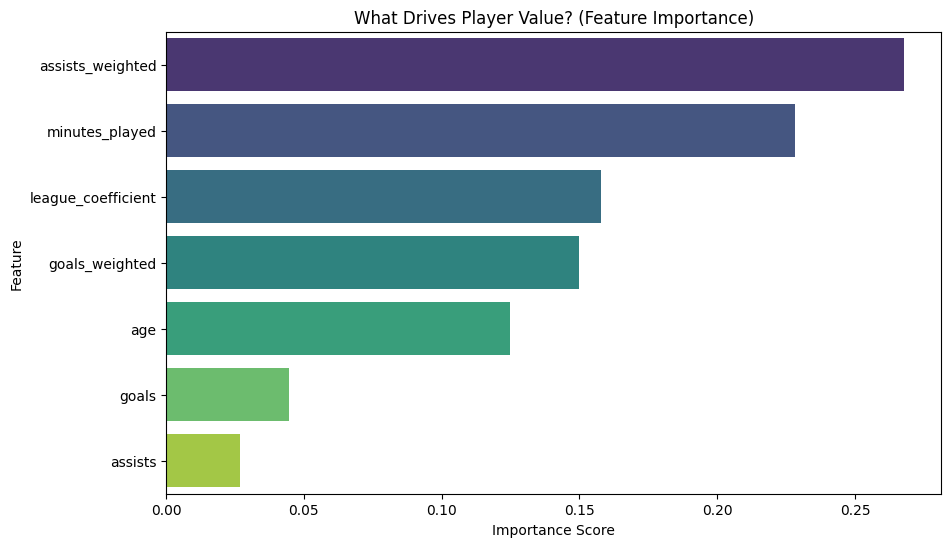

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#1. Get the feature importance from the trained model
importances = model.feature_importances_

#2. Create a DataFrame to organize them
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending = False)

#3. Plot it
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette = 'viridis')
plt.title('What Drives Player Value? (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Using XGBoost to try and Improve the Model

%pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# 1. Define the XGBoost Model
# n_estimators=1000:  It creates 1000 "correction trees"
# learning_rate=0.05: It learns slowly to avoid overreacting (overfitting)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42,
    n_jobs=-1
)

# 2. Train it (same as before)
xgb_model.fit(X_train, Y_train)

# 3. Predict
predictions_xgb = xgb_model.predict(X_test)

# 4. Evaluate
mae_xgb = mean_absolute_error(Y_test, predictions_xgb)
print(f"Random Forest MAE: €{mae:,.0f}") # assuming you saved your old score
print(f"XGBoost MAE:       €{mae_xgb:,.0f}")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Random Forest MAE: €4,313,483
XGBoost MAE:       €4,333,827


In [34]:
# Using log transformation to improve model performance

import numpy as np
from sklearn.metrics import mean_absolute_error

#1. Transform the target (price) to log scale
Y_log = np.log1p(Y)  # log1p is log(1 + x) to handle zero values safely

#2. Split the data
X_train, X_test, Y_log_train, Y_log_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)

#3. Train the random forest model on log-transformed target
model_log = RandomForestRegressor(n_estimators=100, random_state=42)
model_log.fit(X_train, Y_log_train)

#4. Predict on log scale
predictions_log = model_log.predict(X_test)

#5. Reverse the transformation (convert back to Euros)
predictions_back = np.expm1(predictions_log)  # expm1 is exp(x) - 1
y_test_back = np.expm1(Y_log_test)

#6. Check the score
mae_log = mean_absolute_error(y_test_back, predictions_back)
print(f"Random Forest MAE (log-transformed): €{mae_log:,.0f}")
print(f"Previous Random Forest MAE: €{mae:,.0f}")

Random Forest MAE (log-transformed): €3,830,457
Previous Random Forest MAE: €4,313,483


In [38]:
# Log Transformation Error Analysis

#Create a DataFrame of the results
results_log = pd.DataFrame({
    'Player' : df.loc[Y_log_test.index, 'name'],
    'Actual' : y_test_back,
    'Predicted' : predictions_back,
    'Error' : abs(y_test_back - predictions_back)
})

# Sort by Actual value to see the superstars
superstars = results_log.sort_values(by='Actual', ascending=False).head(10)

pd.options.display.float_format = '€{:,.0f}'.format
print(superstars[['Player', 'Actual', 'Predicted', 'Error']])

                     Player       Actual    Predicted       Error
3139        Jude Bellingham €180,000,000 €122,235,031 €57,764,969
1588          Kylian Mbappé €170,000,000  €73,316,726 €96,683,274
3047            Cole Palmer €130,000,000  €70,922,722 €59,077,278
1027         Nicolò Barella  €80,000,000  €32,918,365 €47,081,635
2656  Khvicha Kvaratskhelia  €80,000,000  €19,162,790 €60,837,210
2110               Raphinha  €80,000,000  €89,718,960  €9,718,960
2337     Dominik Szoboszlai  €80,000,000  €46,234,785 €33,765,215
3038            Xavi Simons  €70,000,000  €22,329,415 €47,670,585
2259             Cody Gakpo  €70,000,000  €38,510,790 €31,489,210
3607             João Neves  €65,000,000  €32,235,083 €32,764,917


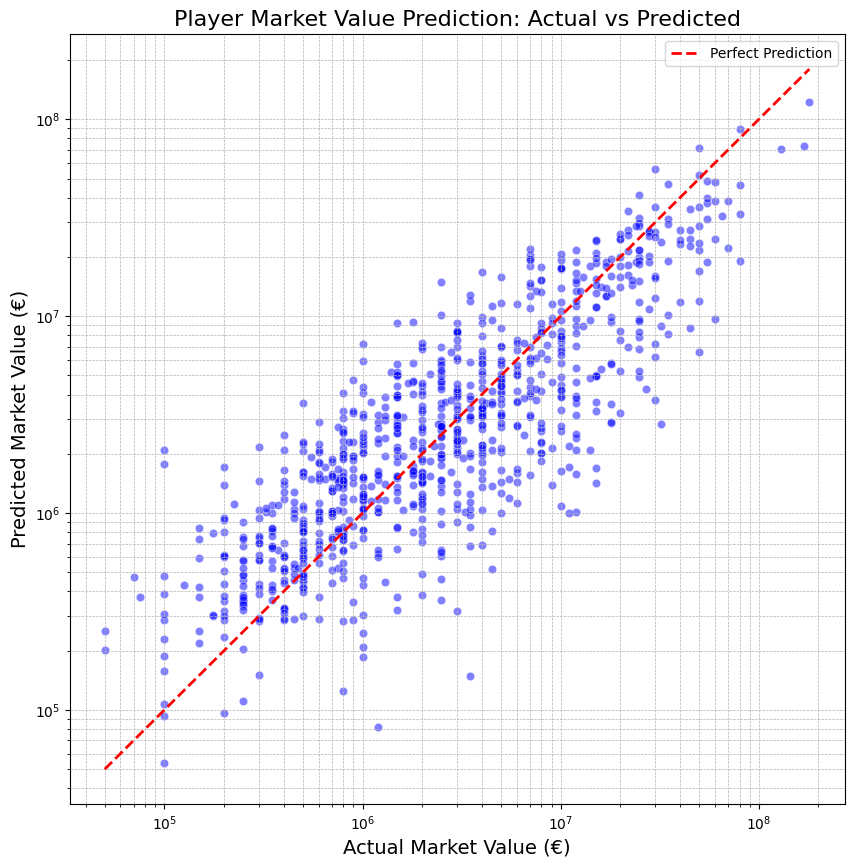

In [ ]:
# Chart for repository README

import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10,10))

#Plot the dots
sns.scatterplot(x='Actual', y='Predicted', data=results_log, alpha=0.5, color='blue')

#Plot the "perfect prediction" line
#If a dot is on this red line the prediction was perfect
min_value = results_log[['Actual', 'Predicted']].min().min()
max_value = results_log[['Actual', 'Predicted']].max().max()
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

#Formatting
plt.title('Player Market Value Prediction: Actual vs Predicted', fontsize=16)
plt.xlabel('Actual Market Value (€)', fontsize=14)
plt.ylabel('Predicted Market Value (€)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Save it
plt.savefig('player_value_prediction.png', dpi=300)
plt.show()